In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/My\Drive/Bin/ORIGINAL.zip

Archive:  drive/MyDrive/Bin/ORIGINAL.zip
   creating: ORIGINAL/FOODWASTE/
  inflating: ORIGINAL/FOODWASTE/FW1.jpg  
  inflating: ORIGINAL/FOODWASTE/FW10.jpg  
  inflating: ORIGINAL/FOODWASTE/FW101.jpg  
  inflating: ORIGINAL/FOODWASTE/FW102.jpg  
  inflating: ORIGINAL/FOODWASTE/FW103.jpg  
  inflating: ORIGINAL/FOODWASTE/FW104.jpg  
  inflating: ORIGINAL/FOODWASTE/FW105.jpg  
  inflating: ORIGINAL/FOODWASTE/FW106.jpg  
  inflating: ORIGINAL/FOODWASTE/FW107.jpg  
  inflating: ORIGINAL/FOODWASTE/FW108.jpg  
  inflating: ORIGINAL/FOODWASTE/FW109.jpg  
  inflating: ORIGINAL/FOODWASTE/FW11.jpg  
  inflating: ORIGINAL/FOODWASTE/FW110.jpg  
  inflating: ORIGINAL/FOODWASTE/FW111.jpg  
  inflating: ORIGINAL/FOODWASTE/FW112.jpg  
  inflating: ORIGINAL/FOODWASTE/FW113.jpg  
  inflating: ORIGINAL/FOODWASTE/FW114.jpg  
  inflating: ORIGINAL/FOODWASTE/FW115.jpg  
  inflating: ORIGINAL/FOODWASTE/FW116.jpg  
  inflating: ORIGINAL/FOODWASTE/FW117.jpg  
  inflating: ORIGINAL/FOODWASTE/FW118.jpg  
  infl

**Dataset Resized**

In [ ]:
!ls ORIGINAL

FOODWASTE  PAPERS  PLASTIC  POLYTHENE


In [ ]:
# import os

# num_skipped = 0
# for folder_name in ("FoodWaste", "Paper","Plastic","Polythene"):
#     folder_path = os.path.join("Waste", folder_name)
#     for fname in os.listdir(folder_path):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
#         finally:
#             fobj.close()

#         if not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

# print("Deleted %d images" % num_skipped)

In [ ]:
import tensorflow as tf

image_size = (180, 180)
batch_size = 32


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "ORIGINAL",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "ORIGINAL",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 603 files belonging to 4 classes.
Using 483 files for training.
Found 603 files belonging to 4 classes.
Using 120 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['FOODWASTE', 'PAPERS', 'PLASTIC', 'POLYTHENE']


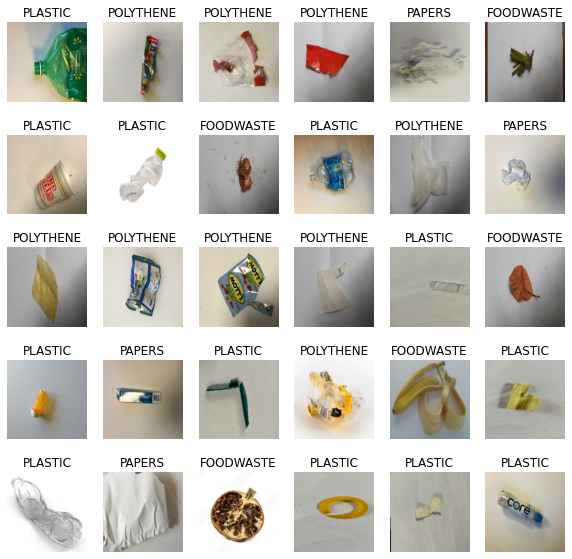

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(30):
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(int(labels[i]))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.3,),
        layers.RandomTranslation((-0.4,0.4),(-0.4,0.4),"nearest","nearest",0,0.3)
    ]
)

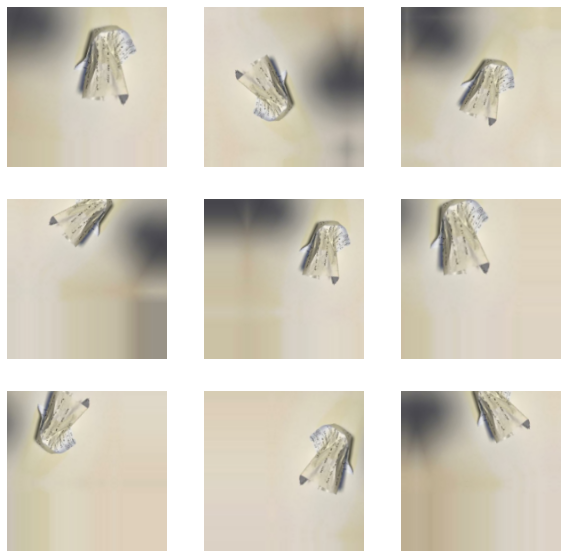

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

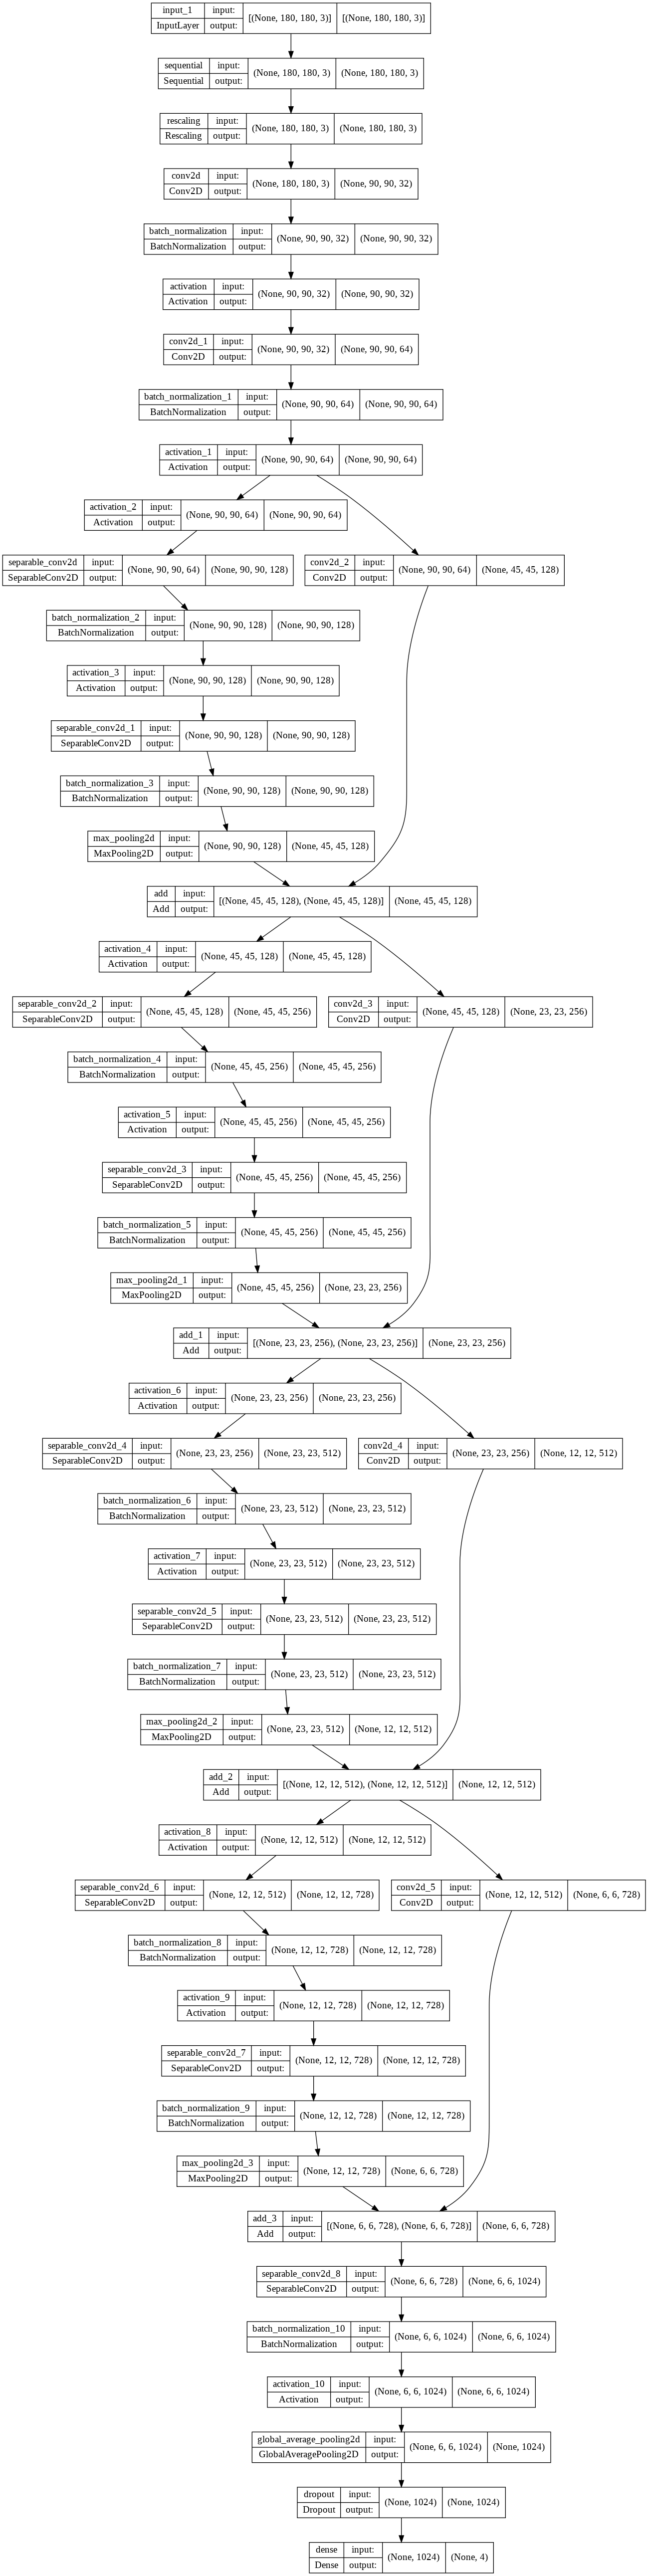

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        # to replace output with a max summary to reduce data size and processing tim

        
        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

!mkdir -p saved_model
model.save('saved_model/my_model')

Epoch 1/50
16/16 [==============================] - 40s 1s/step - loss: 1.4716 - accuracy: 0.4327 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 2/50
16/16 [==============================] - 23s 990ms/step - loss: 1.1606 - accuracy: 0.5383 - val_loss: 1.3877 - val_accuracy: 0.2583
Epoch 3/50
16/16 [==============================] - 23s 1s/step - loss: 1.1287 - accuracy: 0.5362 - val_loss: 1.3934 - val_accuracy: 0.2583
Epoch 4/50
16/16 [==============================] - 22s 984ms/step - loss: 1.1069 - accuracy: 0.5466 - val_loss: 1.4137 - val_accuracy: 0.2500
Epoch 5/50
16/16 [==============================] - 22s 994ms/step - loss: 1.0618 - accuracy: 0.5507 - val_loss: 1.4393 - val_accuracy: 0.2667
Epoch 6/50
16/16 [==============================] - 23s 993ms/step - loss: 1.0326 - accuracy: 0.5424 - val_loss: 1.4446 - val_accuracy: 0.3000
Epoch 7/50
16/16 [==============================] - 22s 993ms/step - loss: 1.0228 - accuracy: 0.5362 - val_loss: 1.4899 - val_accuracy: 0.2500
Epoch

In [ ]:
import numpy as np
img = keras.preprocessing.image.load_img(
    "PLA147.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

preds = model.predict(img_array)
class1 = np.argmax(preds)
#predictions = model.predict_class(img_array)
score = tf.nn.softmax(preds[0])


plt.imshow(img)
plt.show()

print(preds)
print(class1)

if class1 == 0:
  print("Food Waste")

elif class1 == 1:
 print("Paper")

elif class1 == 2:
  print("Plastic")

elif class1 ==3: 
  print("Polythene")

else:
  print("Not Identify")


FileNotFoundError: ignored

Camera Captre

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='Test_FW.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import numpy as np
img = keras.preprocessing.image.load_img(
    "Test_FW.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

preds = model.predict(img_array)
class1 = np.argmax(preds)
#predictions = model.predict_class(img_array)
score = tf.nn.softmax(preds[0])


plt.imshow(img)
plt.show()

print(preds)
print(class1)

if class1 == 0:
  print("Food Waste")

elif class1 == 1:
 print("Paper")

elif class1 == 2:
  print("Plastic")

elif class1 ==3: 
  print("Polythene")

else:
  print("Not Identify")


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
iflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite.model)

OSError: ignored